In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import bert
import math
from bert import tokenization
import tensorflow_hub as hub
from tensorflow.keras import layers
import sentencepiece
import random

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import VotingClassifier
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


# Getting the data

In [3]:
df1 = pd.read_csv("../data/preprocessed_cleaned_body.csv")
df1.head()

,Body,Bias,cleaned_body
0,Abortion rights advocates have asked the U.S. ...,1.67,abortion right advocate asked u supreme court ...
1,A federal appeals court rejected the most dire...,0.67,federal appeal court rejected direct constitut...
2,As part of the Trump administration's effort t...,-2.75,part trump administration effort slow migrant ...
3,"President Donald Trump and ""the Trump of the T...",-4.33,president donald trump trump tropic brazilian ...
4,"U.S Senator Elizabeth Warren, who is competing...",-10.00,u senator elizabeth warren competing democrati...


In [4]:
df2 = pd.read_csv("../data/preprocessed_entity_sentiments.csv")
df2.head()

,Body,Bias,cleaned_body,one,american,trump,two,republican,democrat,first,...,u,cnn,barr,four,thursday,gop,march,chinese,clinton,florida
0,Abortion rights advocates have asked the U.S. ...,1.67,abortion right advocate asked u supreme court ...,0.000000,0.000000,0.000000,0.00000,0.0,0.0000,0.000000,...,0.226738,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A federal appeals court rejected the most dire...,0.67,federal appeal court rejected direct constitut...,0.052867,0.000000,-0.023100,0.00000,0.0,0.0000,0.000000,...,0.157795,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,As part of the Trump administration's effort t...,-2.75,part trump administration effort slow migrant ...,0.000000,0.000000,-0.401825,0.00000,0.0,0.0000,0.000000,...,-0.136091,0.0,-0.060043,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"President Donald Trump and ""the Trump of the T...",-4.33,president donald trump trump tropic brazilian ...,0.246950,0.000000,0.272050,0.29770,0.0,0.0000,0.368767,...,0.301360,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"U.S Senator Elizabeth Warren, who is competing...",-10.00,u senator elizabeth warren competing democrati...,0.173840,0.502567,0.000000,0.42955,0.0,0.3243,0.335250,...,0.274257,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
X = df2['cleaned_body']
X.head()

0    abortion right advocate asked u supreme court ...
1    federal appeal court rejected direct constitut...
2    part trump administration effort slow migrant ...
3    president donald trump trump tropic brazilian ...
4    u senator elizabeth warren competing democrati...
Name: cleaned_body, dtype: object

In [99]:
y = df2['Bias']
y.head()

0     1.67
1     0.67
2    -2.75
3    -4.33
4   -10.00
Name: Bias, dtype: float64

In [100]:
bow_transformer = CountVectorizer(max_features = 500)
bow = bow_transformer.fit_transform(X)

X = pd.DataFrame(bow.toarray(), columns=bow_transformer.get_feature_names())
col_names = X.columns

scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)
X = pd.DataFrame(scaled, columns=col_names)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [101]:
df1['Bias'].describe()

count    1675.000000
mean       -1.974072
std        13.990288
min       -38.250000
25%       -10.000000
50%        -2.000000
75%         3.000000
max        40.000000
Name: Bias, dtype: float64

(array([ 22.,  99., 168., 253., 643., 172.,  95., 134.,  72.,  17.]),
 array([-38.25 , -30.425, -22.6  , -14.775,  -6.95 ,   0.875,   8.7  ,
         16.525,  24.35 ,  32.175,  40.   ]),
 <a list of 10 Patch objects>)

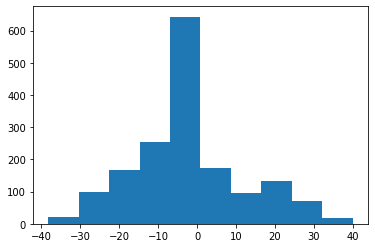

In [102]:
plt.hist(df2['Bias'])

In [185]:
# 1 represents most left, 5 represents most right
bins = [-41, -5, 41]
names = ['0', '0.25', '0.5', '0.75', '1']

multi_df = df2.loc[:]
multi_df['Category'] = pd.cut(multi_df['Bias'], bins, labels=names)

In [186]:
multi_df.head()

,Body,Bias,cleaned_body,one,american,trump,two,republican,democrat,first,...,cnn,barr,four,thursday,gop,march,chinese,clinton,florida,Category
0,Abortion rights advocates have asked the U.S. ...,1.67,abortion right advocate asked u supreme court ...,0.000000,0.000000,0.000000,0.00000,0.0,0.0000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,A federal appeals court rejected the most dire...,0.67,federal appeal court rejected direct constitut...,0.052867,0.000000,-0.023100,0.00000,0.0,0.0000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,As part of the Trump administration's effort t...,-2.75,part trump administration effort slow migrant ...,0.000000,0.000000,-0.401825,0.00000,0.0,0.0000,0.000000,...,0.0,-0.060043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,"President Donald Trump and ""the Trump of the T...",-4.33,president donald trump trump tropic brazilian ...,0.246950,0.000000,0.272050,0.29770,0.0,0.0000,0.368767,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,"U.S Senator Elizabeth Warren, who is competing...",-10.00,u senator elizabeth warren competing democrati...,0.173840,0.502567,0.000000,0.42955,0.0,0.3243,0.335250,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [187]:
#body_df = multi_df.drop(columns=[ 'n_links', 'Source', 'Bias', 'Quality'])

In [188]:
#body_df.head()

In [189]:
# bow_transformer = CountVectorizer(max_features = 800)
# bow = bow_transformer.fit_transform(multi_df['Body'])

# X = pd.DataFrame(bow.toarray(), columns=bow_transformer.get_feature_names())
# y = multi_df['Category']

# col_names = X.columns

# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(X)
# X = pd.DataFrame(scaled, columns=col_names)

X = multi_df['cleaned_body']
y = multi_df['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [190]:
X_train.shape

(1256,)

In [191]:
y_train.shape

(1256,)

In [192]:
X.head()

0    abortion right advocate asked u supreme court ...
1    federal appeal court rejected direct constitut...
2    part trump administration effort slow migrant ...
3    president donald trump trump tropic brazilian ...
4    u senator elizabeth warren competing democrati...
Name: cleaned_body, dtype: object

In [193]:
y.head()

0    2
1    2
2    1
3    1
4    1
Name: Category, dtype: category
Categories (2, object): [1 < 2]

In [194]:
print(multi_df.columns.values)

['Body' 'Bias' 'cleaned_body' 'one' 'american' 'trump' 'two' 'republican'
 'democrat' 'first' 'cohen' 'tuesday' 'congress' 'russian' 'new york'
 'white house' 'russia' 'donald trump' 'democratic' 'today' 'united state'
 'senate' 'million' 'doe' 'last year' 'three' 'washington' 'america'
 'second' 'monday' 'fbi' 'china' 'wednesday' 'north korea' 'year'
 'last week' 'house' 'muslim' 'february' 'new zealand' 'california'
 'april' 'kim' 'u' 'cnn' 'barr' 'four' 'thursday' 'gop' 'march' 'chinese'
 'clinton' 'florida' 'Category']


In [195]:
multi_df.Category.unique()

[2, 1]
Categories (2, object): [1 < 2]

In [196]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [197]:
tokenizer.tokenize("don't be so judgmental")

['don', "'", 't', 'be', 'so', 'judgment', '##al']

In [198]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("dont be so judgmental"))

[2123, 2102, 2022, 2061, 8689, 2389]

In [199]:
def tokenize_data(text_reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_reviews))

In [200]:
tokenized_data = [tokenize_reviews(X) for X in X]

In [201]:
data_with_length = [[X, y[i], len(X)]
                 for i, X in enumerate(tokenized_data)]

In [202]:
random.shuffle(data_with_length)

In [203]:
data_with_len.sort(key=lambda x: x[2])

In [204]:
sorted_data_labels = [(data_lab[0], data_lab[1]) for data_lab in data_with_len]

In [205]:
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_data_labels, output_types=(tf.int32, tf.float32))

In [206]:
BATCH_SIZE = 64
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [207]:
next(iter(batched_dataset))

(<tf.Tensor: shape=(64, 69), dtype=int32, numpy=
 array([[ 2956,  8417,     0, ...,     0,     0,     0],
        [ 2956,  8417,     0, ...,     0,     0,     0],
        [ 1006,  2131,  3723, ...,     0,     0,     0],
        ...,
        [ 1523,  2008,  1521, ...,     0,     0,     0],
        [ 8398,  9828,  2000, ...,     0,     0,     0],
        [ 1006, 13218,  1996, ...,  1997,  2231,  1010]])>,
 <tf.Tensor: shape=(64,), dtype=float32, numpy=
 array([0.5 , 0.5 , 0.5 , 0.5 , 0.25, 1.  , 0.25, 0.5 , 0.5 , 0.25, 0.5 ,
        0.25, 0.  , 0.25, 0.25, 0.5 , 0.  , 0.5 , 0.25, 0.5 , 0.5 , 0.75,
        0.5 , 0.5 , 0.5 , 0.5 , 0.25, 0.25, 0.25, 1.  , 0.75, 0.  , 0.25,
        0.5 , 0.5 , 0.25, 0.25, 0.25, 0.5 , 0.5 , 0.  , 0.5 , 0.  , 0.5 ,
        0.5 , 0.5 , 1.  , 0.25, 0.25, 0.5 , 0.  , 0.25, 0.5 , 0.25, 0.75,
        0.5 , 0.5 , 0.25, 0.5 , 0.  , 0.5 , 0.25, 0.  , 0.25],
       dtype=float32)>)

In [208]:
TOTAL_BATCHES = math.ceil(len(sorted_data_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)

In [209]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [210]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 128
CNN_FILTERS = 100
DNN_UNITS = 512
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.01

NB_EPOCHS = 5

In [211]:
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [212]:
if OUTPUT_CLASSES == 2:
    text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
else:
    text_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])

In [213]:
text_model.fit(train_data, epochs=NB_EPOCHS)

Epoch 1/5
25/25 [==============================]: 0.6953 - accuracy: 0.156 - 1s 317ms/step - loss: 0.7048 - accuracy: 0.164 - 1s 255ms/step - loss: 0.7028 - accuracy: 0.171 - 1s 230ms/step - loss: 0.6998 - accuracy: 0.199 - 1s 217ms/step - loss: 0.6959 - accuracy: 0.203 - 1s 211ms/step - loss: 0.6945 - accuracy: 0.224 - 1s 208ms/step - loss: 0.6950 - accuracy: 0.227 - 2s 208ms/step - loss: 0.7036 - accuracy: 0.220 - 2s 210ms/step - loss: 0.7000 - accuracy: 0.218 - 2s 212ms/step - loss: 0.6978 - accuracy: 0.225 - 2s 215ms/step - loss: 0.6975 - accuracy: 0.227 - 3s 219ms/step - loss: 0.6968 - accuracy: 0.229 - 3s 224ms/step - loss: 0.6963 - accuracy: 0.238 - 3s 230ms/step - loss: 0.6965 - accuracy: 0.232 - 4s 236ms/step - loss: 0.6964 - accuracy: 0.228 - 4s 242ms/step - loss: 0.6958 - accuracy: 0.230 - 4s 250ms/step - loss: 0.6950 - accuracy: 0.232 - 5s 257ms/step - loss: 0.6951 - accuracy: 0.232 - 5s 265ms/step - loss: 0.6929 - accuracy: 0.236 - 5s 274ms/step - loss: 0.6913 - accuracy: 

In [215]:
results = text_model.evaluate(test_data)
results

      2/Unknown - 0s 12ms/step - loss: 0.9397 - accuracy: 0.04 - 0s 15ms/step - loss: 0.8830 - accuracy: 0.13 - 0s 20ms/step - loss: 0.8830 - accuracy: 0.1328

[0.8830295205116272, 0.1328125]

In [218]:
roc_auc = roc_auc_score(y_test, y_probs, average="macro", multi_class="ovo")
print('ROC Score is: ', roc_auc)

NameError: name 'ensemble' is not defined